# Project description

Dataset source is: https://www.kaggle.com/datasets/andrewmvd/udemy-courses
This dataset contains 3.678 records of courses from 4 subjects (Business Finance, Graphic Design, Musical Instruments and Web Design) taken from Udemy.

Aim of the project is to build a model for prediction of course popularity (averaged number of subscribers per day). It is a classification problem: "1" - the course is popular; "0" - the course isn't popular

The project contains EDA of a dataset, ML classifiers models (linear regression and decision tree based) with parameters tuning. The best model is selected on the base of ROC-AUC score values.

# 1. Imports and loading data

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/ElenaNKn/ml-zoomcamp-solutions/master/midterm_project_binary_classification/udemy_courses.csv'
filename = 'udemy_courses.csv'
urllib.request.urlretrieve(url, filename)

('udemy_courses.csv', <http.client.HTTPMessage at 0x2047bd00250>)

In [3]:
df = pd.read_csv('udemy_courses.csv', header=0, sep=',')

# 2. Data cleaning and data preparation

In [4]:
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


In [5]:
df.isnull().sum()   # checking for missing values

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

In [6]:
df.dtypes    # checking types of columns

course_id                int64
course_title            object
url                     object
is_paid                   bool
price                    int64
num_subscribers          int64
num_reviews              int64
num_lectures             int64
level                   object
content_duration       float64
published_timestamp     object
subject                 object
dtype: object

In [7]:
# convert "is_paid" from boolean to categorical variable
df['is_paid'] = df['is_paid'].map({True: 'yes', False: 'no'}) 
df.is_paid.value_counts()   # explore values of "is_paid" column

yes    3368
no      310
Name: is_paid, dtype: int64

In [8]:
df.level.value_counts()   # explore values of "level" column

All Levels            1929
Beginner Level        1270
Intermediate Level     421
Expert Level            58
Name: level, dtype: int64

In [9]:
df.subject.value_counts()    # explore values of "subject" column

Web Development        1200
Business Finance       1195
Musical Instruments     680
Graphic Design          603
Name: subject, dtype: int64

In this project a **popularity** of a course is defined as a ratio of a number of subscribers to an age of a course. An **age** of a course is defined as difference between time of uploading of a course (published_timestamp) and date of data scraping (2020/05/10). In this analysis we'll replace column "published_timestamp" with new column "age".

In [10]:
# create a column of an age of a course (in days)

df.published_timestamp = pd.to_datetime(df.published_timestamp).dt.date
scrap_date = datetime.datetime(2020, 5, 10).date()
df['age'] = [(scrap_date - y) for y in df['published_timestamp']]
df.age = df.age.astype(str).str.strip('days').astype(int)

In [11]:
# create a column "popularity", which is equal to "num_subscribers/age"

df['popularity'] = df.num_subscribers / df.age

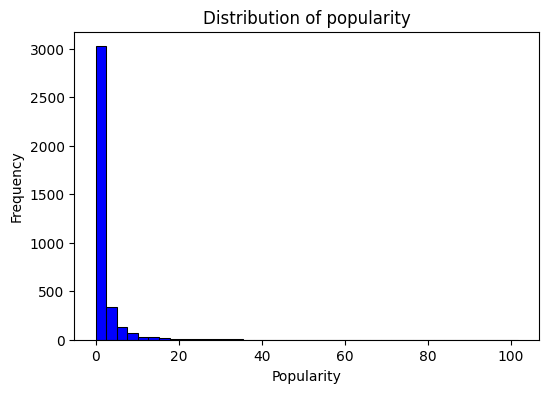

In [12]:
# explore a distribution of "popularity"
plt.figure(figsize=(6, 4))

sns.histplot(df.popularity, bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Popularity')
plt.title('Distribution of popularity')

plt.show()

We see that there's a long tail after popularity=40. Let's checkout how many observation has popularity value greater than 40

In [13]:
df_extrem_popular = df[df['popularity']>=40]
df_extrem_popular

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,age,popularity
2589,473160,Web Design for Web Developers: Build Beautiful...,https://www.udemy.com/web-design-secrets/,no,0,98867,6512,20,All Levels,3.0,2015-04-13,Web Development,1854,53.326321
2783,173548,Build Your First Website in 1 Week with HTML5 ...,https://www.udemy.com/build-your-first-website...,no,0,120291,5924,30,Beginner Level,3.0,2014-04-08,Web Development,2224,54.087680
2827,41295,Learn HTML5 Programming From Scratch,https://www.udemy.com/learn-html5-programming-...,no,0,268923,8629,45,All Levels,10.5,2013-02-14,Web Development,2642,101.787661
3032,59014,Coding for Entrepreneurs Basic,https://www.udemy.com/coding-for-entrepreneurs...,no,0,161029,279,27,Beginner Level,3.5,2013-06-09,Web Development,2527,63.723387
3204,756150,Angular 4 (formerly Angular 2) - The Complete ...,https://www.udemy.com/the-complete-guide-to-an...,yes,190,73783,19649,329,All Levels,22.0,2016-02-11,Web Development,1550,47.601935
3230,625204,The Web Developer Bootcamp,https://www.udemy.com/the-web-developer-bootcamp/,yes,200,121584,27445,342,All Levels,43.0,2015-11-02,Web Development,1651,73.642641
3232,764164,The Complete Web Developer Course 2.0,https://www.udemy.com/the-complete-web-develop...,yes,200,114512,22412,304,All Levels,30.5,2016-03-08,Web Development,1524,75.139108
3247,364426,JavaScript: Understanding the Weird Parts,https://www.udemy.com/understand-javascript/,yes,175,79612,16976,85,All Levels,11.5,2015-03-12,Web Development,1886,42.212089


We obtain that there are 8 observations with extremely high popularity (0.2% of all dataset). They all are from "web development" area (0.67% of all courses from this area). As the percentage of extremely popular courses is not high we'll consider them as outliers and dropp out of consideration.

In [14]:
ind_dropped = df_extrem_popular.index
df.drop(ind_dropped, inplace=True)

In [15]:
# create a list of column names, except "published_timestamp" (as it's replaced with "age"),
# "course_title" and "url" features are also excluded as the course is defined with "course_id" column
# "num_subscribers", "num_reviews" and "age" features are excluded as our business task is to prognose,
# wether course will be popular
list_features = list(df.columns)
list_features.remove('published_timestamp')
list_features.remove('course_title')
list_features.remove('url')
list_features.remove('num_subscribers')
list_features.remove('num_reviews')
list_features.remove('age')
list_features

['course_id',
 'is_paid',
 'price',
 'num_lectures',
 'level',
 'content_duration',
 'subject',
 'popularity']

# 3. Setting up the validation framework

In [16]:
df_full_train, df_test = train_test_split(df[list_features], test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [17]:
len(df_train), len(df_val), len(df_test)

(2202, 734, 734)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [19]:
y_train = df_train.popularity.values
y_val = df_val.popularity.values
y_test = df_test.popularity.values

df_train_target = df_train   # store this matrix for feature importance analysis

del df_train['popularity']
del df_val['popularity']
del df_test['popularity']

# 4. Exploratory data analysis

## 4.1. Target value analysis and handling

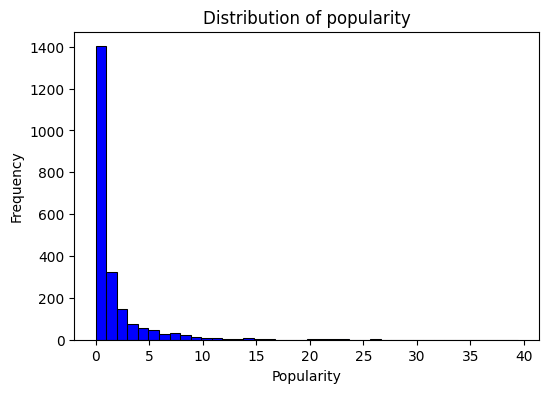

In [20]:
# explore a distribution of "popularity" for train data
plt.figure(figsize=(6, 4))

sns.histplot(y_train, bins=40, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Popularity')
plt.title('Distribution of popularity')

plt.show()

We see that there are just a few observations with popularity greater than 10 (subscribers per day). While most of courses has from 0 to 3 subscribers per day.

The distribution of target value is similar to Poisson distribution. And mean value depends significantly from just a few observations (most popular courses). In this case we'll set median value as a threshold to consider courses popular/unpopular.

In [21]:
def target_handle(y):
    popularity_threshold = np.median(y_train)
    y = (y<popularity_threshold).astype(int)
    return y

In [22]:
y_train = target_handle(y_train)

In [23]:
# check the correctness of target handling. Counting a quantity of popular/unpopular courses
np.array(np.unique(y_train, return_counts=True))

array([[   0,    1],
       [1101, 1101]], dtype=int64)

In [24]:
y_val = target_handle(y_val)
y_test = target_handle(y_test)

## 4.2. Feature importance analysis

In [25]:
df_train.head()

,course_id,is_paid,price,num_lectures,level,content_duration,subject
0,554384,yes,95,70,All Levels,13.5,Web Development
1,1009622,yes,80,43,Beginner Level,5.5,Graphic Design
2,1178150,yes,20,8,All Levels,1.0,Business Finance
3,267286,yes,35,10,Beginner Level,1.0,Web Development
4,1246252,yes,65,14,Beginner Level,2.0,Graphic Design


In [26]:
# checking types of features
df_train.dtypes

course_id             int64
is_paid              object
price                 int64
num_lectures          int64
level                object
content_duration    float64
subject              object
dtype: object

So we have categorical features: is_paid, level and subject. The other features are numerical.

In [27]:
categorical = ['is_paid', 'level', 'subject']

In [28]:
# in feature importance analysis we'll consider numerical features except "course_id"
numerical = ['price',
    'num_lectures',
    'content_duration']

### 4.2.1. Mutual information

Now we'll consider mutual information for categorical 

In [29]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, y_train)

In [30]:
mi = df_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

subject    0.122093
is_paid    0.033276
level      0.004233
dtype: float64

Results above shows that a target value 'popularity' depends significantly of a 'subject' of a course. The fact of whether is course free of charge or not play less important role. And the level of a course affects just slightly on a target value 'popularity'.

### 4.2.3. Correlation

In [31]:
df_train_with_target = pd.concat([df_train[numerical], pd.DataFrame(y_train, columns=['popularity'])], axis=1)
df_train_with_target

,price,num_lectures,content_duration,popularity
0,95,70,13.5,0
1,80,43,5.5,1
2,20,8,1.0,1
3,35,10,1.0,0
4,65,14,2.0,1
...,...,...,...,...
2197,50,15,2.5,1
2198,50,80,11.0,0
2199,45,112,3.0,1
2200,0,22,1.5,0


In [32]:
df_train_with_target[numerical].corrwith(df_train_with_target.popularity).abs()

price               0.177435
num_lectures        0.126851
content_duration    0.124418
dtype: float64

In [33]:
df_train_corr = df_train_with_target.corr()
df_train_corr

,price,num_lectures,content_duration,popularity
price,1.000000,0.331459,0.308325,-0.177435
num_lectures,0.331459,1.000000,0.822149,-0.126851
content_duration,0.308325,0.822149,1.000000,-0.124418
popularity,-0.177435,-0.126851,-0.124418,1.000000


In [34]:
df_train_corr.unstack().sort_values()

price             popularity         -0.177435
popularity        price              -0.177435
num_lectures      popularity         -0.126851
popularity        num_lectures       -0.126851
content_duration  popularity         -0.124418
popularity        content_duration   -0.124418
price             content_duration    0.308325
content_duration  price               0.308325
price             num_lectures        0.331459
num_lectures      price               0.331459
                  content_duration    0.822149
content_duration  num_lectures        0.822149
price             price               1.000000
num_lectures      num_lectures        1.000000
content_duration  content_duration    1.000000
popularity        popularity          1.000000
dtype: float64

We've obtained that 'price', 'content_duration' and 'num_lectures' effect on a target value almost equally. But their effect is not significant.

# 5. One-hot encoding

In [35]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# 6. Linear regression classifier model, parameters tuning

In [36]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import roc_auc_score

In [37]:
model = RidgeClassifier()
model.fit(X_train, y_train)

RidgeClassifier()

In [38]:
y_pred = model.predict(X_val)
popular = (y_pred>=0.5)
roc_auc_score(y_val, popular)

0.7695213917159055

Let's investigate, whether solver affects on the results of model and it's ROC-AUC score.

In [39]:
solver_list = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
solver_roc_auc = dict()
for s in solver_list:
    model = RidgeClassifier(solver=s)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    popular = (y_pred>=0.5)
    rocauc = roc_auc_score(y_val, popular)
    solver_roc_auc[s] = rocauc

In [40]:
solver_roc_auc

{'svd': 0.7695213917159055,
 'cholesky': 0.7695213917159055,
 'lsqr': 0.4928744205552186,
 'sparse_cg': 0.5855893299783574,
 'sag': 0.509390937071735,
 'saga': 0.499872690645758}

From the results obtained we see that 'svd' and 'cholesky' solvers led to better results.

Now we'll tune parameter alpha of the linear regression classifier model. This is regularization strength; must be a positive float.

In [41]:
scores = []

for s in ['svd', 'cholesky']:
    for a in [0.05, 0.1, 1, 5, 10]:
        model = RidgeClassifier(solver=s, alpha=a)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        popular = (y_pred>=0.5)
        rocauc = roc_auc_score(y_val, popular)
        scores.append((s, a, rocauc))

In [42]:
columns = ['solver', 'alpha', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [43]:
df_scores_pivot = df_scores.pivot(index='alpha', columns=['solver'], values=['auc'])
df_scores_pivot

auc          
solver  cholesky       svd
alpha                     
0.05    0.769521  0.769521
0.10    0.769521  0.769521
1.00    0.769521  0.769521
5.00    0.770768  0.770768
10.00   0.770768  0.770768

We see that alpha value doesn't play role in our case. So the total linear regression classifier model is the next

In [44]:
model_lin = RidgeClassifier(solver='svd')
model_lin.fit(X_train, y_train)
y_pred = model_lin.predict(X_val)
popular = (y_pred>=0.5)
roc_auc_score(y_val, popular)

0.7695213917159055

# 7. Decision tree classifier model, parameters tuning

In [45]:
from sklearn.tree import DecisionTreeClassifier

In [46]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [47]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6807830274164439

In [48]:
print('depth   roc-auc')
for depth in range(1, 11, 1): 
    dt = DecisionTreeClassifier(max_depth=depth, random_state=1)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s     %.3f' % (depth, auc))

depth   roc-auc
   1     0.707
   2     0.755
   3     0.808
   4     0.813
   5     0.813
   6     0.808
   7     0.798
   8     0.780
   9     0.772
  10     0.760


From the results obtained we see that best ROC-AUC score is for depth = [4, 5]. Now let's find optimal min_samples_leaf

In [49]:
scores = []

for depth in [4, 5]:
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [50]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [51]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc       
max_depth             4      5
min_samples_leaf              
1                 0.813  0.813
5                 0.816  0.817
10                0.820  0.824
15                0.821  0.824
20                0.815  0.823
50                0.804  0.812
100               0.776  0.779
200               0.775  0.775

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

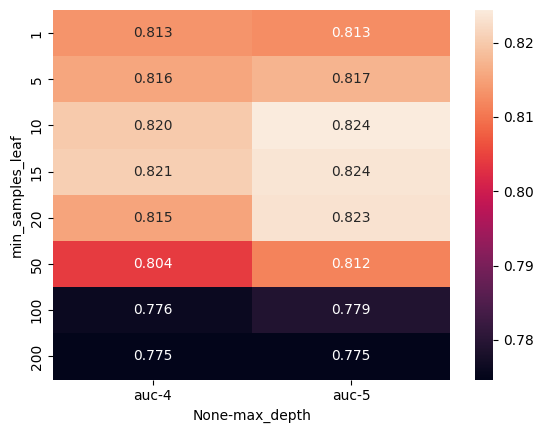

In [52]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

We obtained that the best decision tree model has the next parameters: depth = 5 and min_samples_leaf = 10. A final decision tree classifier model is build with above described parameters.

In [53]:
dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=1)

In [54]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8243804902159015

# 8. Random forest classifier, parameters tuning

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246875304231913

Let's also tune parameters of this model: n_estimators, max_depth and min_sample_leaf

In [57]:
scores = []

for d in range(1, 15, 4):
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [58]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

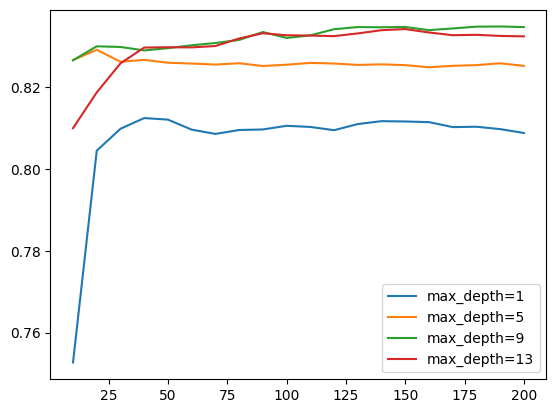

In [59]:
for d in range(1, 15, 4):
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

It's shown that ROC-AUC values for max_depth=[9, 13] are close, but max_depth=9 is a little bit better.

Now we'll tune min_sample_leaf parameter

In [60]:
scores = []

for s in [1, 3, 5, 7, 9]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=9,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [61]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

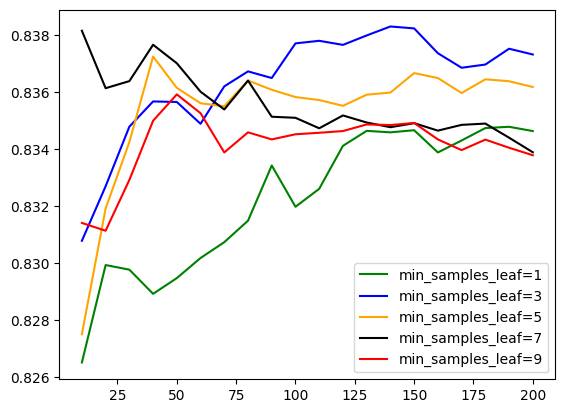

In [62]:
colors = ['green', 'blue', 'orange', 'black', 'red']
values = [1, 3, 5, 7, 9]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

We see that best results are obtained for min_samplwes_leaf=3. And there is an optimal number of n_estimators between 130 and 160. Let's determine it

In [63]:
scores = []

for n in range(130, 161, 1):
    rf = RandomForestClassifier(n_estimators=n,
                                max_depth=9,
                                min_samples_leaf=3,
                                random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [64]:
scores

[(130, 0.8379726359776235),
 (131, 0.8380999453318655),
 (132, 0.8378078826956632),
 (133, 0.8379801247631671),
 (134, 0.8378153714812069),
 (135, 0.838152366830671),
 (136, 0.838002591119798),
 (137, 0.8380325462619729),
 (138, 0.8381523668306711),
 (139, 0.8381598556162146),
 (140, 0.8382871649704567),
 (141, 0.8381074341174093),
 (142, 0.8380550126186037),
 (143, 0.8382197659005639),
 (144, 0.8380175686908854),
 (145, 0.8380400350475165),
 (146, 0.8381823219728456),
 (147, 0.8379651471920799),
 (148, 0.8383395864692622),
 (149, 0.8382646986138257),
 (150, 0.8382197659005638),
 (151, 0.8381598556162148),
 (152, 0.8380849677607782),
 (153, 0.8379951023342544),
 (154, 0.8378677929800125),
 (155, 0.8377329948402268),
 (156, 0.8375682415582666),
 (157, 0.8373660443485879),
 (158, 0.837366044348588),
 (159, 0.8373885107052188),
 (160, 0.8373510667775007)]

ROC-AUC score has the closest to 1 value for n_estimators=148. So a final random forest classifier model is the next

In [65]:
rf = RandomForestClassifier(n_estimators=148,
                            max_depth=9,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8383395864692622

# 9. Final model

Three classifier models are built:<br> - linear regression classifier model ***model_lin***. It's ROC-AUC score is equal to 0.7695 on validation dataset <br> - decision tree classifier model ***dt***. It's ROC-AUC score is equal to 0.824 on validation dataset <br> - random forest classifier model ***rf***. It's ROC-AUC score is equal to 0.838 on validation dataset

On the base of ROC-AUC score we select as final model random forest classifier model with previously tuned parameters. Now we'll train this model on train+validation dataset

In [66]:
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.popularity.values

del df_full_train['popularity']

In [67]:
y_full_train = target_handle(y_full_train)

In [68]:
dv = DictVectorizer(sparse=False)

train_dict = df_full_train.to_dict(orient='records')
X_full_train = dv.fit_transform(train_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

In [69]:
rf.fit(X_full_train, y_full_train)

y_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.835135135135135

We obtained that our model works on test dataset after training on train+validation dataset. It's ROC-AUC score became a little bit lower, but still better than ones for linear regression and decision tree models.

# Conclusion

1. Dataset preparation and cleaning were performed. In this project a "popularity" of a course were defined as a ratio of a number of subscribers to an age of a course. An "age" of a course was defined as a difference between the date of uploading of a course (published_timestamp) and the date of data scraping. During the analysis of popularity distribution we obtained that there were 8 observations with extremely high popularity (0.2% of all dataset). They all were from "web development" area (0.67% of all courses from this area). As the percentage of extremely popular courses was not high we considered them as outliers and dropped out of a consideration.

2. Exploratory data analysis (EDA) was performed. It was obtained that the distribution of a target value 'popularity' is similar to a Poisson distribution. In this project target variable mean value depends significantly from just a few observations (most popular courses). In this case we set median value as a threshold to consider courses popular/unpopular, i.e. a course is considered to be popular if it's popularity is greater then median of all courses'popularities. Thus 'popularity' target variable was converted to variable with 0/1 values.<br> Based on the business task modeling was performed for the next features ['course_id', 'is_paid', 'price', 'num_lectures', 'level', 'content_duration', 'subject'] and target variable 'popularity'.

3. Feature importance analysis was also performed in the frame of EDA. It was obtained that a target value 'popularity' depends significantly of a 'subject' of a course. The fact of whether is course free of charge or not plays less important role. And the level of a course effects just slightly on a target value 'popularity'. Correlation analysis showed that 'price', 'content_duration' and 'num_lectures' effect on a target value almost equally. But their effect is not significant.

4. Three classifier models are built:
- linear regression classifier model with tuned parameters. It's ROC-AUC score is equal to 0.770 on validation dataset
- decision tree classifier model with tuned parameters. It's ROC-AUC score is equal to 0.824 on validation dataset
- random forest classifier model with tuned parameters. It's ROC-AUC score is equal to 0.838 on validation dataset

5. Random forest classifier model is selected as a final model. It's parameters: <br> *n_estimators* = 148, <br> *max_depth* = 9, <br> *min_samples_leaf* = 3 <br> The model was trained on test+validation dataset and showed ROC-AUC score of 0.835 on test dataset

saving the model

In [70]:
import pickle

In [71]:
output_file = 'model.bin'

In [72]:
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, rf), f_out)

loading the model

In [73]:
import pickle

In [74]:
input_file = 'model.bin'

In [75]:
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [76]:
model

RandomForestClassifier(max_depth=9, min_samples_leaf=3, n_estimators=148,
                       random_state=1)